# First Try at Implementing VFI

In [ ]:
!pip install interpolation

     |████████████████████████████████| 56 kB 2.8 MB/s 


Then let's pull in the package libraries we'll need:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from interpolation import interp
from scipy.optimize import minimize_scalar, bisect

In [ ]:
def maximize(g, a, b, args):

    objective = lambda x: -g(x, *args) #define obj function
    #minimize the negative
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    #define output
    maximizer, maximum = result.x, -result.fun


    #return
    return maximizer, maximum

#Example of maximize in action
#Note that you *do not* specify the first argument of the function 
  #(because that's what maximize() will check over)
def f(x,a,c):
  return a*(x-c)**2

print(f(0,-1,0))
        #f, a, b,  a , c
maximize(f,-10,10,(-1,0))

0


(0.0, -0.0)

Let's build a class, called `Reputation` to store $\beta$ and $\gamma$ as well as a `state_action_value` method which computes the utility for a certain consumption choice and guessed value function.


In [ ]:
class Reputation:

    def __init__(self,
                 ρ=0.96,            # degree of relative risk aversion
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        #NGL, I have no idea what this actually does
        self.ρ = ρ

        # Set up grid (of input values)
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, c):

        γ = self.γ

        if γ == 1:
            return np.log(c)
        else:
            return (c ** (1 - γ)) / (1 - γ)

    # first derivative of utility function. (done algebraically)
    def u_prime(self, c):

        return c ** (-self.γ)
 
    # 
    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        #call the utility function and beta from the object
        u, β = self.u, self.β

        # Define the v function which uses linear interpolation
          # recall we ran: "from interpolation import interp"
        # lambda allows us to define a function on the spot
          # since it's "lambda": x, x is the input 
          #(because v_arry and x_grid are passed from before)
        v = lambda x: interp(self.x_grid, v_array, x)

        #so v(x) returns the interpolated value of x_grid,v_array at x
        #return the utility you get now u(c), plus the 
        #guess at optimal utility play given x-c consumption 
        #This is the RHS of Bellman equation

        #Basically, supposed optimal utility carrying forward savings x
        return u(c) + β * v(x - c)


*   Note that `CakeEating` is a class.
*   Note that `CakeEating()` will create an object of class `CakeEating` with the default parameters.
* Note `CakeEating(params)` will create an object of class `CakeEating` with the specified `params`.

With that knowledge, we can define the Bellman operator (remember that?):

In [ ]:
def T(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function (array).

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    # make an empty vector with the same shape as v
    v_new = np.empty_like(v)

    #enumerate make i the counter and allows x to be the value
    #making lists of categoricals nice to loop over

                          #note that we pull the x.grid from the object 'ce'
                          #of class CakeEating that is passed to T(v,ce)
                          #We do not use CakeEating().x_grid
    for i, x in enumerate(ce.x_grid):
        # Maximize RHS of Bellman equation at state x
            #maximize ce's state action value function
        
        #Note that an x in ce.x_grid corresponds to the size of the pie at
          # present, so the max pie we could consume now x 
            #(first x in maximize)
          #And the size of present pie determines v(x-c),
            #(second x in maximize)

        # We defined maximize as follows: def maximize(g, a, b, args):
        # where g is the objective function
        # a is the start, b is the end points,
        # and args are the arguments for g, the obj function 
                            #note you do not specify consumption
                            #bc maximize is using that argument to max over
                            #g                      #a    #b  #args
        v_new[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[1]
        #maximize returns "maximizer, maximum", 
          #so we select the *second* item, maximum

    return v_new

In [ ]:
#Define a Cake Eating Problem (object) with Default Params
ce=CakeEating()
ce.u(10)

-0.6324555320336759

Finally, we can solve the model. Let's start by guessing that the value function is simply the utility function (it won't be), and this guess is arbitrary, although we might assume they have roughly similar shapes, so it's a decent guess probably:

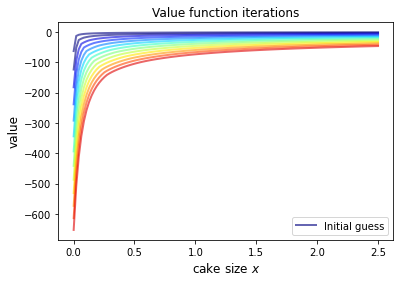

In [ ]:
#Let's try with a "good" guess v(x)=u(x)
x_grid = ce.x_grid
v = ce.u(x_grid)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots() #define an empty plot (objects)

#Plot the initial guess
ax.plot(x_grid, v, #x and y values
        color=plt.cm.jet(0),#select first color in color ramp, 
                            #(for color gradient)
        lw=2, #line width
        alpha=0.6, #transparency
        label='Initial guess')

# For the number of iterations rerun Bellman Operator
for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator to update v
    ax.plot(x_grid, v, 
            color=plt.cm.jet(i / n),#color ramp goes from 0 to 1, this 
                                    #this evenly spaces them
            lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

### Finding Equilibrium
But this is pretty unscientific. Why 12 guesses? No reason. Let's see if we can rigourously compute convergence.

In [ ]:
def compute_value_function(ce, # an object of class CakeEating
                           tol=1e-4, # the stopping tolerance
                           max_iter=1000, # the bailout number of iters
                           verbose=True, # the thing to run with/w/o messages
                           print_skip=25): # frequency of printout
    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess, just the zero function
    i = 0 #starting iterator
    error = tol + 1 # starting value of tolerance

    #run loop as long as error is too big and haven't gone too many times
    while i < max_iter and error > tol:
        v_new = T(v, ce) #bellman operate

        #this is a bad way of computing error (should probably be RMSE)
        error = np.max(np.abs(v - v_new))
        
        #error = np.sqrt(np.mean((v-v_new)**2))
        i += 1 #note this way of incrementing

        # If at a print step, print current error
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        # update v to new guess
        v = v_new
    # if we reach bailout, bailout
    if i == max_iter:
        print("Failed to converge!")
    # if converged and verbose, say so
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    # return convergent value function (or the last one at bailout)
    return v_new

Let's try to use this:

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545588948.
Error at iteration 250 is 0.0024412443051460286.
Error at iteration 275 is 0.000879816432870939.
Error at iteration 300 is 0.00031708295398402697.
Error at iteration 325 is 0.00011427565573285392.

Converged in 329 iterations.


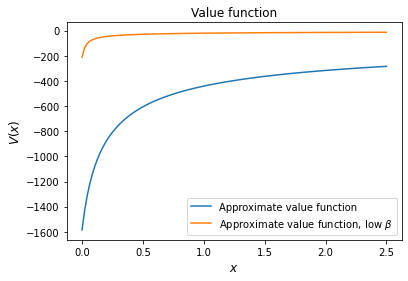

In [ ]:
v = compute_value_function(ce)

fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.plot(x_grid, compute_value_function(CakeEating(.7),verbose=False), label=r'Approximate value function, low $\beta$')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

### Policy Function
We should convert the value function into the policy function numerically as well. We can do that in the numerically in the following way:
$$
\sigma(x)=\arg\max_{0\leq c\leq x}\left\{ u(c) +\beta v(x-c)\right\}
$$

But oh happy days! We just computed $v$, so this is not a problem.

In [ ]:
def σ(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce is an instance of CakeEating
    * v is a value function array

    """
    c = np.empty_like(v) # empty placeholder vector

    for i in range(len(ce.x_grid)): 
        x = ce.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[0]
        #select the first item, maximizer
    return c



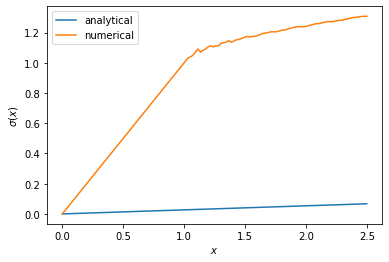

In [ ]:
#Compute consumption with optimal value function:
c = σ(ce, v)

c_analytical = c_star(ce.x_grid, ce.β, ce.γ)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()